In [85]:
import os
import PyPDF2
import re
import psycopg2
import sys
import datetime

def walk_dir(dir,fileinfo,topdown=True):
    for root, dirs, files in os.walk(dir, topdown):
        for name in files:
            #print(os.path.join(name))
            fileinfo.write(os.path.join(root,name) + '\n')
        #for name in dirs:
            #print(os.path.join(name))
            #fileinfo.write('  ' + os.path.join(root,name) + '\n')

def parse(directory,cur):
    lists=[]
    r = ""
    start_time=""
    end_time=""
    pdfFileObj = open(directory, 'rb')
    pdfReader = PyPDF2.PdfFileReader(pdfFileObj)
    num_pages = pdfReader.numPages
    for i in range(num_pages):
        pageObj = pdfReader.getPage(i)
        text = pageObj.extractText()

        text = text.replace("\n","")
        text = text.replace("Œ","-")
        text = text.replace("™","'")
        text = text.replace("˚","ffi")
        text = text.replace("˛","ff")
        text = text.replace("˜","fi")
        text = text.replace("˝","fl")

        content=text.split("Notice is hereby ")
        for j in range(len(content)):
            if j == 0:
                regions  = re.split("((?:[A-Z])(?:[A-Z|\.]+\s)+(?:REGION))", content[0])
            else:
                content=content[1].split("etc.)")
                regions  = re.split("((?:[A-Z])(?:[A-Z|\.]+\s)+(?:REGION))", content[1])

            for region in regions:
               
               county = ""

               if re.search('.+(REGION)',region):
                   #print("----------------------------")
                   #print(region.strip())
                   r = str(region)
                   #do_nothing=""
               else:
                  area_ints = region.split("AREA: ")
                  for area_int in area_ints:
                      areas = area_int.split("& adjacent customers.")
                      long_street = "" 
                      for area in areas:

                         if re.search('COUNTY',area):
                            #print("----------------------------")
                            #print(area)
                            county = str(area)
                            #do_nothing=""
                         else:

                             if not re.search('^\s*$',area):
                                #print("----------------------------")
                                data = area
                                a=""
                                date=""
                                time=""

                                if re.search('.*(?=DATE)',data):
                                    area_break = re.search('.*(?=DATE)',data).end()
                                    a = data[:area_break].strip()
                                    data = data[area_break+len("DATE: "):]

                                if re.search('.*(?=TIME)',area):
                                    date_break = re.search('.*(?=TIME)',data).end()
                                    date = data[:date_break].strip()
                                    data = data[date_break+len("TIME:"):]
                                    try:
                                        day_break=re.search('(?=[0-9]+)',date).end()
                                        date_=date[day_break:]
                                        day_break=re.search('[0-9]+',date_).end()
                                        day = date_[:day_break].strip()
                                        date_ = date_[day_break:]
                                        month_break=re.search('(?=[0-9]+)',date_).end()
                                        date_=date_[month_break:]
                                        month_break=re.search('[0-9]+',date_).end()
                                        month = date_[:month_break].strip()
                                        date_=date_[month_break:]
                                        year_break=re.search('(?=[0-9]+)',date_).end()
                                        date_=date_[year_break:]
                                        year_break=re.search('[0-9]+',date_).end()
                                        year = date_[:year_break].strip()
                                        date=year+'-'+month+'-'+day
                                    except Exception as e:
                                        print(e)
                                        print(directory)
                                        print(date)
                                        print("----------------------------")

                                if re.search('(A\.M|P\.M).*(A\.M|P\.M(\.)?)',area):
                                    time_break = re.search('(A\.M|P\.M).*(A\.M|P\.M(\.)?)', data).end()
                                    times = data[:time_break].strip()
                                    data = data[time_break:]
                                    start_time=""
                                    end_time=""
                                    try:
                                        time=re.split("-|Š",times)
                                        start_time=time[0]
                                        end_time=time[1]
                                        
                                        hour_break=re.search('(?=[0-9]+)',start_time).end()
                                        start_time=start_time[hour_break:]
                                        hour_break=re.search('[0-9]+',start_time).end()
                                        hour=start_time[:hour_break].strip()
                                        start_time=start_time[hour_break+1:]
                                        minute_break=re.search('[0-9]+',start_time).end()
                                        minute=start_time[:minute_break].strip()
                                        start_time=start_time[minute_break:]
                                        time=hour+':'+minute+' '
                                        if re.search('A',start_time):
                                            time+='AM'
                                        else:
                                            time+='PM'
                                        start_time=time
                                        
                                        hour_break=re.search('(?=[0-9]+)',end_time).end()
                                        end_time=end_time[hour_break:]
                                        hour_break=re.search('[0-9]+',end_time).end()
                                        hour=end_time[:hour_break].strip()
                                        end_time=end_time[hour_break+1:]
                                        minute_break=re.search('[0-9]+',end_time).end()
                                        minute=end_time[:minute_break].strip()
                                        end_time=end_time[minute_break:]
                                        time=hour+':'+minute+' '
                                        if re.search('A',end_time):
                                            time+='AM'
                                        else:
                                            time+='PM'
                                        end_time=time
                                        
                                    except Exception as e:
                                        print(e)
                                        print(directory)
                                        print(times)
                                        print("----------------------------")

                                if re.search('customers.',data):
                                    ending_break = re.search('customers.',data).end()
                                    data = data[:ending_break-len(" & adjacent customers.")]

                                #print(a + " : " + date + " : " + times)
                                areas_=a.split(",")
                                
                                '''   
                                sub_locs = data.split(",")
                                for sub_loc in sub_locs:
                                  if re.search('\d+(st|nd|rd|th)$',sub_loc):
                                     long_street += sub_loc.strip()
                                     long_street += ", "
                                  else:
                                     place = long_street + sub_loc.strip()
                                     #print(place)
                                     place = place.replace("\ufb02","")
                                     place = place.replace("\ufb01","")
                                     place = place.replace("\u201a","")
                                     a = a.replace("\xc1","")
                                     #outcome.write(county + '_' + r + '_' + a + '_' + place + '\n')
                                     ''' 
                                for area_ in areas_:
                                     if re.search('PART OF|PARTS OF',area_):
                                            area__break=re.search('PART OF|PARTS OF',area_).end()
                                            area_=area_[area__break:].strip()
                                     list = []
                                     list.append(date)
                                     list.append(start_time)
                                     list.append(end_time)
                                     #list.append(county)
                                     list.append(r)
                                     list.append(area_.strip())
                                     #list.append(place)
                                     #print(list[0])
                                     for j in range(len(list)):
                                         if list[j]=="":
                                            list[j]=None
                                     #crap = str(county + '_' + r + '_' + a + '_' + place)
                                     #list.append(crap)
                                        
                                     length=""
                                     try:
                                         date_time=date+" "+start_time
                                         start=datetime.datetime.strptime(date_time,"%Y-%m-%d %I:%M %p")
                                         date_time=date+" "+end_time
                                         end=datetime.datetime.strptime(date_time,"%Y-%m-%d %I:%M %p")
                                         length=end-start
                                         list.append(length)
                                         lists.append(list)
                                     except Exception as e:
                                        print(e)
                                        print(directory)
                                        print(list)
                                        print("----------------------------")
                                     
                                     '''
                                     try:
                                         cur.execute("INSERT INTO outages (date,start_time,end_time,region,area,length)\
                                         VALUES (%s, %s, %s, %s, %s, %s)",\
                                        (list[0],list[1],list[2],list[3],list[4],list[5]))
                                     except Exception as e:
                                        print(e)
                                        print(directory)
                                        print(list)
                                        print("----------------------------")
                                     '''
                                     long_street = ""
    pdfFileObj.close()
    return lists
                                    
dir = r'C:\GridWatch\Parsing service interruptions\test' #dir of folder
fileinfo = open('C:\\GridWatch\\Parsing service interruptions\\test2.txt','w')
walk_dir(dir,fileinfo)
fileinfo.close()

f = open('C:\\GridWatch\\Parsing service interruptions\\test2.txt','r')
#o = open('C:\\GridWatch\\Parsing service interruptions\\list1.txt','w')
#con = psycopg2.connect(database='outage_map', user='postgres') 
con = psycopg2.connect(database='capstone', user='capstone', password='capstone', host='141.212.11.206', port='5432')
con.autocommit = True
cur = con.cursor()
cur.execute("DROP TABLE IF EXISTS outages")
cur.execute("CREATE TABLE outages(index SERIAL PRIMARY KEY)")
cur.execute("ALTER TABLE outages ADD date date")
cur.execute("ALTER TABLE outages ADD start_time time")
cur.execute("ALTER TABLE outages ADD end_time time")
#cur.execute("ALTER TABLE outages ADD county text")
cur.execute("ALTER TABLE outages ADD region text")
cur.execute("ALTER TABLE outages ADD area text")
#cur.execute("ALTER TABLE outages ADD place text")
#cur.execute("ALTER TABLE outages ADD c_r_a_p text")
cur.execute("ALTER TABLE outages ADD length interval")
outages=[]
for line in f:
    #print("----------------------------")
    directory = line.replace("\n","")
    #print(directory)
    lists = parse(directory,cur)
    for element in lists:
        outages.append(element)
try:
    dataText = ', '.join(map(bytes.decode,(cur.mogrify('(%s, %s, %s, %s, %s, %s)', element) for element in outages)))
    cur.execute('INSERT INTO outages (date,start_time,end_time,region,area,length) VALUES ' + dataText)
except Exception as e:
    print(e)
    print(element)
    print("----------------------------")
f.close()
#o.close()
con.commit()
print("finish")

finish


In [19]:
import psycopg2
import sys
'''
cur.execute("SELECT * FROM outages")
rows = cur.fetchall()
for row in rows:
    print(row)
'''
con = psycopg2.connect(database='outage_map', user='postgres')
con.autocommit = True
cur = con.cursor()
cur.execute("SELECT MAX(index) FROM outages")
count = cur.fetchall()
print(count[0])

(23752,)


In [28]:
cur.execute("SELECT region, area, COUNT(area) FROM outages GROUP BY region, area HAVING COUNT(area)>=3 ORDER BY COUNT(area) DESC")
rows = cur.fetchall()
for row in rows:
    print(row[0], row[1],row[2])

COAST REGION MOMBASA ISLAND 145
NAIROBI REGION MOMBASA ROAD 138
NAIROBI REGION WESTLANDS 103
NAIROBI REGION INDUSTRIAL AREA 93
NAIROBI REGION KAREN 89
NAIROBI REGION NGONG ROAD 63
NAIROBI REGION KILIMANI 62
NAIROBI REGION LANGATA 60
NAIROBI REGION KANGUNDO ROAD 60
NAIROBI REGION SYOKIMAU 58
COAST REGION CHANGAMWE 58
NAIROBI REGION LAVINGTON 57
NAIROBI REGION GITHUNGURI 55
COAST REGION KIEMBENI 53
NAIROBI REGION KISERIAN 51
NAIROBI REGION KILELESHWA 50
COAST REGION NYALI 50
COAST REGION LIKONI 49
NAIROBI REGION GITHIGA 49
COAST REGION BAMBURI 47
NAIROBI REGION KIBERA 46
NAIROBI REGION RUAI 44
COAST REGION MTONGWE 43
NAIROBI REGION RUNDA 43
NAIROBI REGION IKINU 42
COAST REGION MSAMBWENI 42
COAST REGION SHANZU 41
NAIROBI REGION WAIYAKI WAY 41
COAST REGION KALOLENI 40
NAIROBI REGION SOUTH C 39
COAST REGION KWALE 39
COAST REGION MALINDI 38
COAST REGION KONGOWEA 38
COAST REGION MTWAPA 38
COAST REGION MAZERAS 37
NAIROBI REGION PARKLANDS 37
NAIROBI REGION RUIRU 37
NAIROBI REGION NAMANGA 36
NAI

In [21]:
cur.execute("SELECT length, COUNT(length) FROM outages GROUP BY length ORDER BY length DESC")
rows = cur.fetchall()
for row in rows:
    print(row[0], row[1])

15:00:00 7
14:00:00 6
13:00:00 18
12:30:00 11
12:00:00 220
11:30:00 28
11:00:00 195
10:30:00 32
10:00:00 498
9:45:00 2
9:30:00 250
9:15:00 1
9:00:00 3652
8:45:00 37
8:30:00 1163
8:15:00 4
8:00:00 11786
7:57:00 2
7:30:00 678
7:00:00 1879
6:30:00 172
6:00:00 1395
5:30:00 90
5:00:00 667
4:30:00 52
4:00:00 270
3:30:00 48
3:00:00 272
2:30:00 36
2:00:00 142
1:30:00 21
1:00:00 52
0:30:00 16
0:20:00 10
-1 day, 22:00:00 8
-1 day, 21:00:00 4
-1 day, 20:00:00 11
-1 day, 19:30:00 2
-1 day, 18:00:00 7
-1 day, 4:00:00 4
-1 day, 3:00:00 4


In [22]:
cur.execute("SELECT start_time, COUNT(start_time) FROM outages GROUP BY start_time ORDER BY COUNT(start_time) DESC")
rows = cur.fetchall()
for row in rows:
    print(row[0], row[1])

09:00:00 15099
08:00:00 4825
08:30:00 2075
07:00:00 542
06:00:00 310
10:00:00 253
09:30:00 250
07:30:00 196
06:30:00 56
12:00:00 26
14:00:00 26
13:00:00 23
11:30:00 14
11:00:00 9
21:00:00 9
20:00:00 8
23:00:00 8
16:00:00 8
01:00:00 6
08:45:00 4
08:03:00 2
12:30:00 1
00:00:00 1
07:45:00 1


In [23]:
cur.execute("SELECT end_time, COUNT(end_time) FROM outages GROUP BY end_time ORDER BY COUNT(end_time) DESC")
rows = cur.fetchall()
for row in rows:
    print(row[0], row[1])

17:00:00 15964
16:00:00 2734
15:00:00 1691
18:00:00 888
14:00:00 770
16:30:00 551
13:00:00 343
12:00:00 262
11:00:00 87
15:30:00 81
17:30:00 48
12:30:00 47
16:45:00 39
10:00:00 35
18:30:00 34
13:30:00 29
19:00:00 28
11:30:00 22
09:00:00 12
14:30:00 12
08:30:00 11
08:00:00 11
09:20:00 10
10:30:00 8
05:00:00 7
03:00:00 7
02:00:00 5
09:30:00 4
04:30:00 3
23:00:00 3
23:30:00 3
04:00:00 2
22:00:00 1


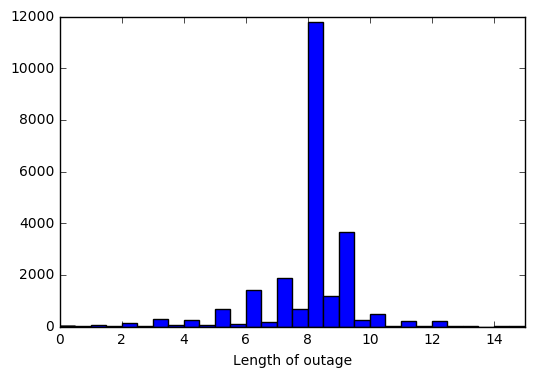

In [24]:
import matplotlib.pyplot as plt
import numpy as np
cur.execute("SELECT length FROM outages")
rows = cur.fetchall()

a=np.array([])
for row in rows:
    time_float = row[0].total_seconds() /3600
    a=np.insert(a,0,time_float)
plt.hist(a,bins=np.arange(0,15.5,0.5))
plt.xlim(0,15)
plt.xlabel('Length of outage')
plt.show()

In [25]:
cur.execute("SELECT DISTINCT region,COUNT(*) FROM outages GROUP BY region ORDER BY COUNT(*) DESC")
rows = cur.fetchall()
for row in rows:
    print(row[0],row[1])

NAIROBI REGION 7422
WEST REGION 4715
MT KENYA REGION 3740
COAST REGION 2628
CENTRAL RIFT REGION 832
NORTH EASTERN REGION 829
MT. KENYA REGION 804
NAIROBI NORTH REGION 572
NAIROBI WEST REGION 558
NAIROBI SOUTH REGION 493
NORTH RIFT REGION 460
WESTERN REGION 337
SOUTH NYANZA REGION 270
KENYA REGION 50
WEST KENYA REGION 30
None 12


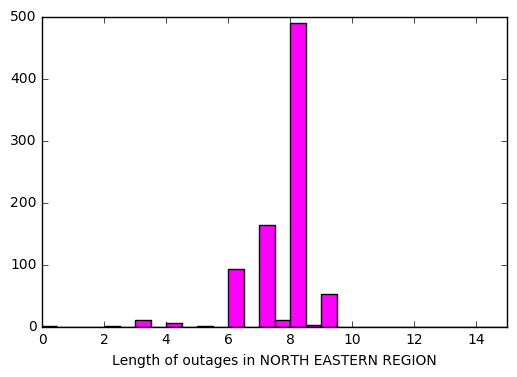

In [38]:
import matplotlib.pyplot as plt
import numpy as np
cur.execute("SELECT length FROM outages WHERE region='NORTH EASTERN REGION'")
rows = cur.fetchall()

a=np.array([])
for row in rows:
    time_float = row[0].total_seconds() /3600
    a=np.insert(a,0,time_float)
plt.hist(a,bins=np.arange(0,15.5,0.5),color='magenta')
plt.xlim(0,15)
plt.xlabel('Length of outages in NORTH EASTERN REGION')
plt.show()

In [41]:
cur.execute("SELECT region, area, sum(length) FROM outages GROUP BY region, area ORDER BY sum(length) DESC")
rows = cur.fetchall()
for row in rows:
    print(row[0], row[1],row[2])

COAST REGION MOMBASA ISLAND 50 days, 10:00:00
NAIROBI REGION MOMBASA ROAD 44 days, 13:00:00
NAIROBI REGION WESTLANDS 32 days, 2:00:00
NAIROBI REGION KAREN 29 days, 12:30:00
NAIROBI REGION INDUSTRIAL AREA 29 days, 2:00:00
NAIROBI REGION NGONG ROAD 20 days, 21:30:00
NAIROBI REGION KILIMANI 20 days, 7:00:00
NAIROBI REGION LANGATA 20 days, 1:00:00
COAST REGION CHANGAMWE 19 days, 17:00:00
NAIROBI REGION LAVINGTON 19 days, 1:00:00
NAIROBI REGION GITHUNGURI 18 days, 23:00:00
COAST REGION KIEMBENI 18 days, 17:30:00
NAIROBI REGION SYOKIMAU 18 days, 14:30:00
NAIROBI REGION KANGUNDO ROAD 17 days, 14:30:00
COAST REGION NYALI 17 days, 10:00:00
NAIROBI REGION KISERIAN 17 days, 1:00:00
NAIROBI REGION GITHIGA 16 days, 11:00:00
NAIROBI REGION KILELESHWA 16 days, 11:00:00
COAST REGION LIKONI 16 days, 8:30:00
COAST REGION BAMBURI 15 days, 15:00:00
NAIROBI REGION KIBERA 15 days, 13:00:00
NAIROBI REGION IKINU 14 days, 7:00:00
COAST REGION MSAMBWENI 14 days, 3:00:00
COAST REGION MTONGWE 14 days, 0:30:00
COA

In [84]:
cur.execute("SELECT end_time, COUNT(end_time) FROM outages GROUP BY region,end_time HAVING region='MT KENYA REGION' or region='MT. KENYA REGION' ORDER BY COUNT(end_time) DESC")
rows = cur.fetchall()
for row in rows:
    print(row[0], row[1])

17:00:00 2093
16:00:00 560
15:00:00 378
17:00:00 369
14:00:00 220
18:00:00 208
16:00:00 199
16:30:00 167
13:00:00 80
16:30:00 48
12:00:00 37
15:00:00 21
18:00:00 21
10:00:00 18
11:00:00 17
17:30:00 12
09:00:00 12
08:00:00 11
08:30:00 11
09:20:00 10
12:00:00 7
19:00:00 7
17:30:00 6
15:30:00 6
14:00:00 6
13:00:00 6
12:30:00 4
14:30:00 3
23:30:00 3
18:30:00 2
22:00:00 1
13:30:00 1
